In [1]:
import dolfin as d
import fenics
import matplotlib.pyplot as plt
import numpy as np

import scipy.optimize

import ipywidgets

In [2]:
r_maj = 5.5
r_min = 1.5

class DirichletBoundary(d.SubDomain):
    def inside(self, x, on_boundary):
        #if not on_boundary:
        #    return False
        
        dx = np.asarray(x) - (r_maj, 0)
        return np.linalg.norm(dx) > r_min

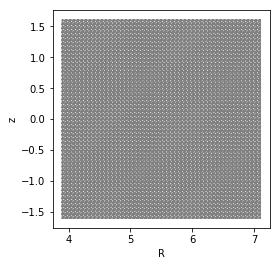

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [3]:
# Create and plot mesh
border = 0.1
mesh = d.RectangleMesh(d.Point(r_maj - r_min - border, -r_min - border), d.Point(r_maj + r_min + border, r_min + border), 50, 50)
fenics.plot(mesh)
plt.xlabel('R')
plt.ylabel('z')
plt.show()

V = d.FunctionSpace(mesh, 'CG', 1)

In [4]:
# Boundary condition
zero = d.Constant(0)
boundary_condition = d.DirichletBC(V, zero, DirichletBoundary())

In [5]:
# Variational problem
psi = d.Function(V, name = 'psi')
v = d.TestFunction(V)
r = d.Expression('x[0]', degree = 1)
z = d.Expression('x[1]', degree = 1)

In [6]:
def grad_shafranov(j0, ja, p0, pa, psi0j, psi0p, jbase):    
    def sigmoid(x):
        return 1 / (1 + d.exp(-x))
    
    mu_0 = 4e-7 * np.pi

    psi_var = d.variable(psi)
    
    def profile(y0, a, psi0):
        return y0 * sigmoid((psi_var - psi0) * a)

    # Define target current profile
    j0 = d.Constant(j0)
    ja = d.Constant(ja)
    psi0j = d.Constant(psi0j)
    j_target = profile(-j0, ja, psi0j) - d.Constant(jbase)

    # Define target pressure profile
    p0 = d.Constant(p0)
    pa = d.Constant(pa)
    psi0p = d.Constant(psi0p)
    p  = profile(p0, pa, psi0p)
    dp  = d.diff(p, psi_var)

    # Choose j so that it matches the target current profile at the mean radius location
    rj_phi = j_target - (r**2 - r_maj**2) * dp
    rj_phi = -abs(rj_phi)
    
    dGsq = -2 * mu_0 * (j_target + r_maj**2 * dp)
    
    grad_shafranov_rhs = -1/r * d.inner(d.grad(psi), d.grad(v)) * d.dx
    grad_shafranov_lhs = mu_0 * rj_phi / r * v * d.dx

    grad_shafranov_equation = (
        grad_shafranov_rhs - grad_shafranov_lhs == 0
    )
    
    err = d.grad(psi)
    
    return grad_shafranov_equation, rj_phi, p, dGsq, d.inner(err, err)

In [12]:
def solve_for(jan, j0, pan, p0, psinj, psinp, jbase):    
    psiv = np.vectorize(psi)
    
    def do_solve(ja, pa, psi0j, psi0p):
        arr = grad_shafranov(ja = ja, j0 = j0, pa = pa, p0 = p0, psi0j = psi0j, psi0p = psi0p, jbase = jbase)
        eqn = arr[0]
        
        d.solve(eqn, psi, boundary_condition, solver_parameters = dict(
            newton_solver = dict(
                relaxation_parameter = 1.0
            )
        ))
        
        return arr[1:]
    
    def get_psi_max():
        # Estimate maximum psi
        rr = np.linspace(r_maj - r_min, r_maj + r_min, 50)
        rz = np.linspace(      - r_min,         r_min, 50)
        
        gr, gz = np.meshgrid(rr, rz, indexing = 'ij')
        
        gpsi = psiv(gr, gz)
        return np.amax(gpsi)
    
    # Initial solution
    psi.vector()[:] = 0
    do_solve(ja = 0, pa = 0,psi0j = 0, psi0p = 0)
    
    psi0 = psi.copy(deepcopy = True)
    psi_max = get_psi_max()
    
    #print('Pre-solution finished')
    
    #for scale in np.linspace(0, 1, int(2 * jan)):
    scales = [0, 0.5, 1]
    for i_scale, scale in enumerate(scales):
        print('Solving with scale factor {} ({} / {})'.format(scale, i_scale + 1, len(scales)))
        def solve_with_psimax(psi_max):
            #print('\tTrying psi_max = {}'.format(psi_max))
            ja = jan * scale / psi_max
            pa = pan * scale / psi_max
            psi0j = psinj * psi_max
            psi0p = psinp * psi_max

            result = do_solve(ja = ja, pa = pa, psi0j = psi0j, psi0p = psi0p)

            return result
        
        try:
            solve_with_psimax(psi_max)
            psi_max_2 = get_psi_max()
            #print('\tGot psi_max = {}'.format(psi_max_2))
        except:
            psi_max_2 = np.inf
        
        # If our psi_max estimate is inaccurate, use a fancier approach
        if scale == 1 or np.abs(psi_max_2 - psi_max) > 0.1:            
            scale_factor = psi_max_2 / psi_max
            
            def error_function(x):
                success = False
                for scale in [1, scale_factor, 0.5, 2]:
                    #print('\tTrying scale {}'.format(scale))
                    psi.vector()[:] = psi0.vector() * scale

                    try:
                        solve_with_psimax(x[0])
                        success = True
                        break
                    except KeyboardInterrupt:
                        raise
                    except:
                        #print('\t\tSolver failure')
                        pass

                if not success:
                    raise ValueError('Failed to obtain solution')

                psi_max = get_psi_max()
                #print('\t\tObtained solution with psi_max = {}'.format(psi_max))

                return [x[0] - psi_max]
            
            # Try to find root of error_function
            root = scipy.optimize.root(error_function, (psi_max))
            psi_max = root.x[0]
            #solve_with_psimax(psi_max)
        else:
            psi_max = psi_max_2
        
        psi0.vector()[:] = psi.vector()
    
    return solve_with_psimax(psi_max)

In [13]:
def plot_gs_solution(jan, j0, pan, p0, psinj, psinp, jbase, b0 = 1, prefix = ''):    
    j_phi, p, dGsq, _ = solve_for(jan = jan, j0 = j0, pan = pan, p0 = p0, psinj = psinj, psinp = psinp, jbase = jbase)
    
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def profile(x, y0, an, psin):
        x = x / psi_max
        return y0 * sigmoid((x - psin) * an)
    
    psiv = np.vectorize(psi)

    ax_r = np.linspace(r_maj - r_min, r_maj + r_min, 100)
    ax_z = np.linspace(      - r_min,       + r_min, 100)

    g_r, g_z = np.meshgrid(ax_r, ax_z)
    
    g_psi = psiv(g_r, g_z)
    psi_max = np.amax(g_psi)
    
    def save(name):
        if prefix == '':
            return
        
        plt.savefig(prefix + name + '.png')
    
    plt.figure()
    plt.contour(g_psi, levels = np.sqrt(np.linspace(0.01, 1, 15)) * psi_max, extent = [r_maj - r_min, r_maj + r_min, -r_min, r_min])
    plt.axis('equal')
    save('contour')
    
    ax_psi = np.linspace(0, psi_max, 100)
    
    prof_j = profile(ax_psi, j0, jan, psinj) + jbase
    prof_p = profile(ax_psi, p0, pan, psinp)
    
    plt.figure()
    plt.plot(ax_psi, prof_j * 1e-3)
    plt.vlines([psinj * psi_max], 0, np.amax(prof_j) * 1e-3, lw = 1)
    plt.hlines([0.5e-3 * j0 + 1e-3 * jbase, 1e-3 * j0 + 1e-3 * jbase], 0, psi_max, lw = 1)
    plt.xlim(0, np.amax(ax_psi))
    plt.title('Current density [kA]')
    plt.xlabel('$\\psi$')
    save('current_profile')
    
    plt.figure()
    plt.plot(ax_psi, prof_p)
    plt.vlines([psinp * psi_max], 0, np.amax(prof_p), lw = 1)
    plt.hlines([0.5 * p0, p0], 0, psi_max, lw = 1)
    plt.xlim(0, np.amax(ax_psi))
    plt.title('Pressure [Pa]')
    plt.xlabel('$\\psi$')
    save('pressure_profile')
    
    plt.figure()
    plt.plot(ax_r, psiv(ax_r, 0))
    plt.title('$\\psi$ at z=0')
    plt.xlabel('R [m]')
    save('poloidal_flux')
    
    plt.figure()
    m = d.plot(-j_phi * 1e-3)
    plt.colorbar(m)
    plt.title('Toroidal current density [kA]')
    plt.show()
    save('current_density')
    
    plt.figure()
    m = d.plot(p)
    plt.colorbar(m)
    plt.show()
    save('pressure_density')
    
    g_dGsq = np.vectorize(lambda x, y: dGsq((x, y)))(g_r, g_z)
    
    ind = np.argsort(g_psi, axis = None)
    
    x = g_psi.reshape([-1])[ind]
    y = g_dGsq.reshape([-1])[ind]
    
    plt.figure()
    plt.plot(x, y)
    plt.xlabel('$\\psi$')
    plt.ylabel('$d/d\\psi G^2$')
    plt.show()
    
    Gsq = 0.5 * np.cumsum((y[1:] + y[:-1]) * (x[1:] - x[:-1]))#np.trapz(x, y)
    Gsq = np.concatenate([[0], Gsq])
    #b0 = max(b0, -np.sqrt(np.amin(Gsq)))
    c0  = max((b0*r_maj)**2, -np.sqrt(np.amin(Gsq)))
    G = np.sqrt(Gsq + c0)
    
    plt.figure()
    plt.plot(x, np.degrees(np.arctan2(1, G)))
    plt.xlabel('$\\psi$')
    plt.ylabel('G')
    plt.title('Toroidal flux-function')
    plt.show()
    save('tf')
    
    g_G = np.zeros([g_psi.size])
    g_G[ind] = G
    g_G = g_G.reshape(g_psi.shape)
    g_Bphi = g_G / g_r
    del g_G
    
    plt.figure()
    plt.imshow(g_Bphi, origin = 'lower', extent = [r_maj - r_min, r_maj + r_min, -r_min, r_min])
    plt.colorbar()
    plt.title('$B_{\\phi}$')
    plt.show()
    save('toroidal_field')
    
    g_grad_psi = np.gradient(g_psi, ax_z, ax_r)
    g_Btheta = np.linalg.norm(g_grad_psi, axis = 0) / g_r
    
    plt.figure()
    plt.imshow(g_Btheta, origin = 'lower', extent = [r_maj - r_min, r_maj + r_min, -r_min, r_min])
    plt.colorbar()
    plt.title('$B_{pol}$')
    plt.show()
    save('poloidal_field')
    
    plt.figure()
    plt.imshow(np.degrees(np.arctan2(g_Btheta, g_Bphi)), origin = 'lower', extent = [r_maj - r_min, r_maj + r_min, -r_min, r_min])
    plt.colorbar()
    plt.title('Pitch angle')
    plt.show()
    save('pitch_angle')

#plot_gs_solution(jan = 10, j0 = 1e7, pan = 10, p0 = 1e5, psinj = 0.7, psinp = 0.7)

@ipywidgets.interact_manual
def tokamak(
    jprofile_width = ipywidgets.FloatSlider(1.0, min = 0.1, max = 2),
    pprofile_width = ipywidgets.FloatSlider(1.0, min = 0.1, max = 2),
    jprofile_loc   = ipywidgets.FloatSlider(0.5, min = 0, max = 1),
    pprofile_loc   = ipywidgets.FloatSlider(0.5, min = 0, max = 1),
    j0             = ipywidgets.FloatSlider(1e6, min = 0, max = 1e7),
    p0             = ipywidgets.FloatSlider(1e5, min = 0, max = 1e6),
    jbase          = ipywidgets.FloatSlider(1e5, min = 0, max = 1e6),
    b0             = ipywidgets.FloatSlider(1, min = 0, max = 2),
    prefix         = ipywidgets.Text('')
):
    jan = 10 / jprofile_width
    pan = 10 / pprofile_width
    
    plot_gs_solution(jan = jan, j0 = j0, psinj = jprofile_loc, pan = pan, p0 = p0, psinp = pprofile_loc, jbase = jbase, b0 = b0, prefix = prefix)

interactive(children=(FloatSlider(value=1.0, description='jprofile_width', max=2.0, min=0.1), FloatSlider(valu…

Solving with scale factor 0 (1 / 3)
Solving with scale factor 0.5 (2 / 3)
Solving with scale factor 1 (3 / 3)
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


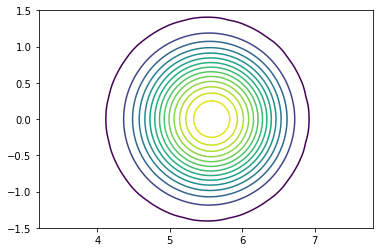

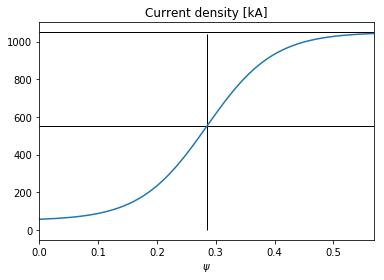

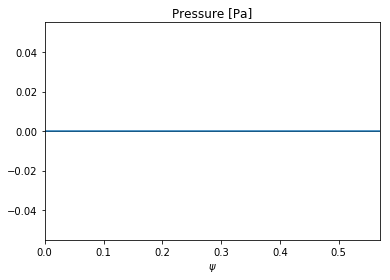

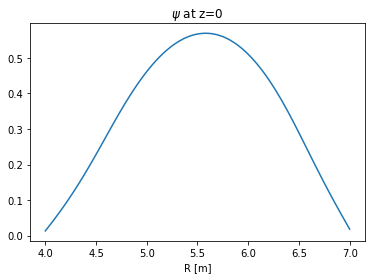

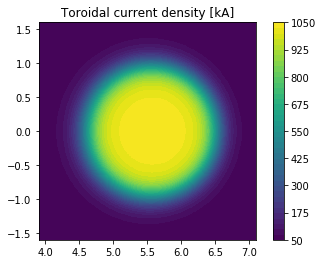

Calling FFC just-in-time (JIT) compiler, this may take some time.


<Figure size 432x288 with 0 Axes>

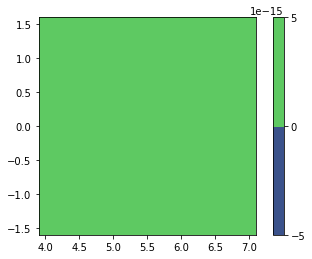

<Figure size 432x288 with 0 Axes>

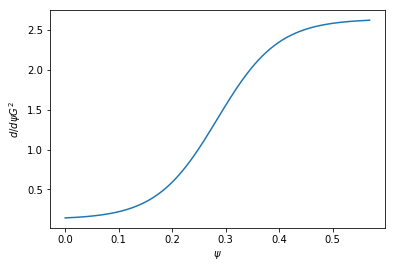

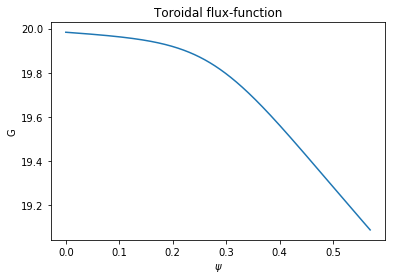

<Figure size 432x288 with 0 Axes>

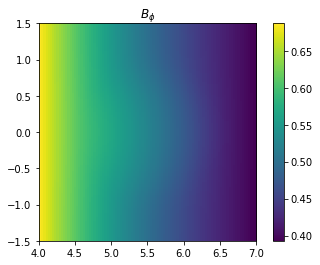

<Figure size 432x288 with 0 Axes>

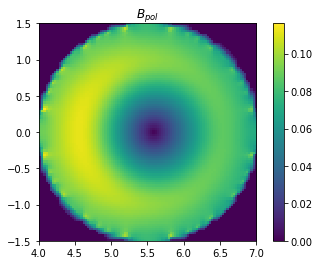

<Figure size 432x288 with 0 Axes>

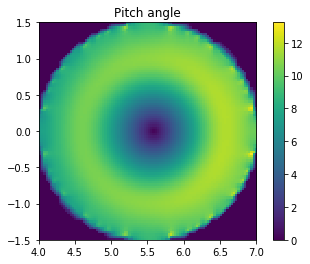

<Figure size 432x288 with 0 Axes>

In [14]:
tokamak(
    jprofile_width = 1.0,
    pprofile_width = 1.0,
    jprofile_loc   = 0.5,
    pprofile_loc   = 0.5,
    j0             = 1e6,
    p0             = 0,
    jbase = 5e4,
    b0 = 0.5,
    prefix = 'vacuum_'
)

Solving with scale factor 0
Solving with scale factor 0.5
Solving with scale factor 1


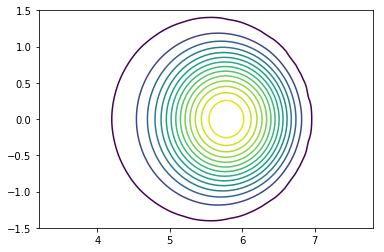

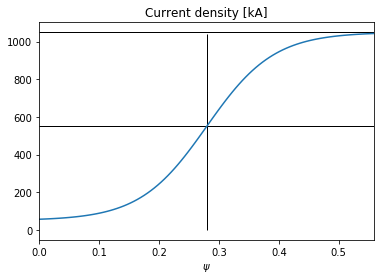

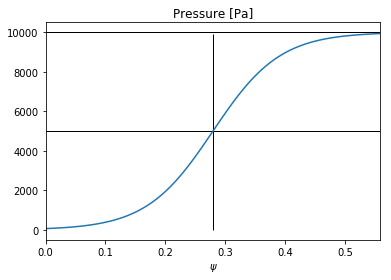

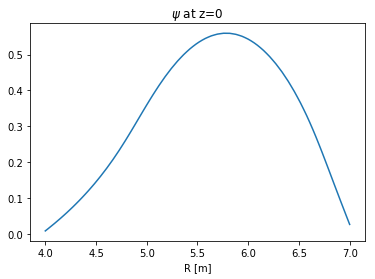

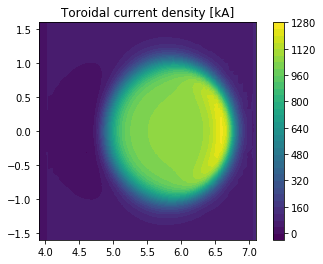

<Figure size 432x288 with 0 Axes>

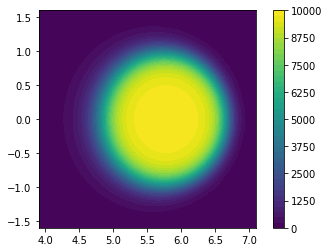

<Figure size 432x288 with 0 Axes>

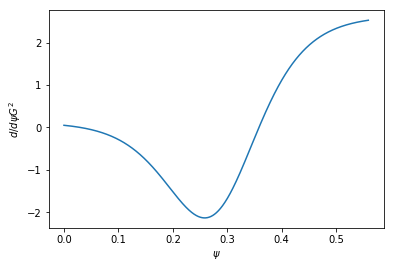

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt


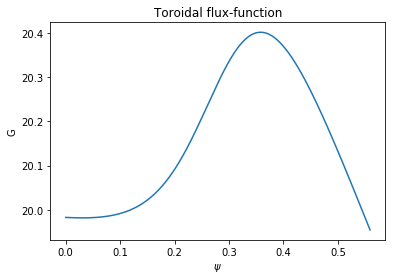

<Figure size 432x288 with 0 Axes>

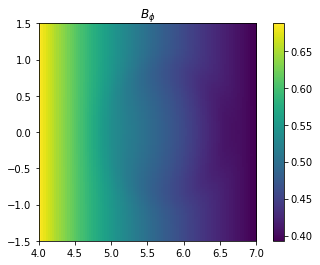

<Figure size 432x288 with 0 Axes>

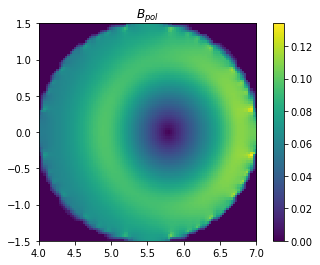

<Figure size 432x288 with 0 Axes>

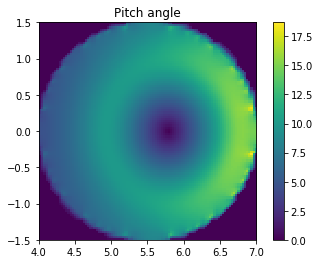

<Figure size 432x288 with 0 Axes>

In [349]:
tokamak(
    jprofile_width = 1.0,
    pprofile_width = 1.0,
    jprofile_loc   = 0.5,
    pprofile_loc   = 0.5,
    j0             = 1e6,
    p0             = 1e4,
    jbase = 5e4,
    b0 = 0.5,
    prefix = 'case1_'
)

Solving with scale factor 0
Solving with scale factor 0.5
Solving with scale factor 1


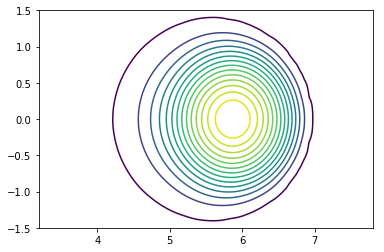

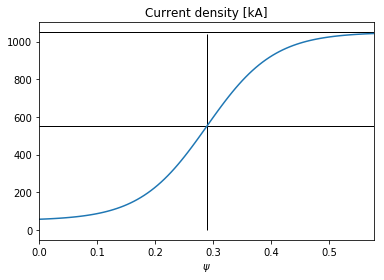

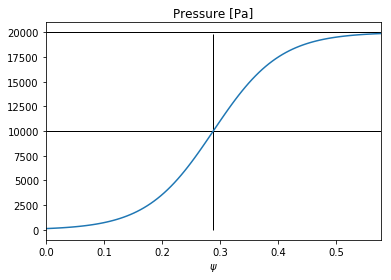

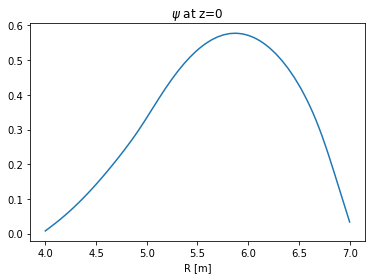

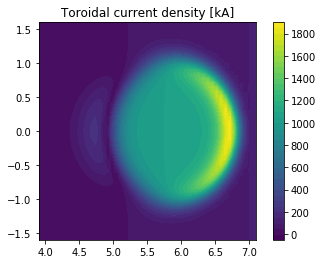

<Figure size 432x288 with 0 Axes>

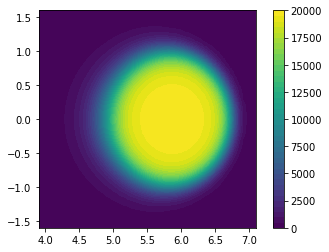

<Figure size 432x288 with 0 Axes>

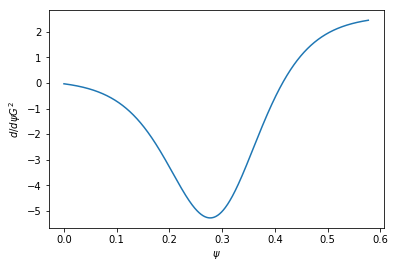

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt


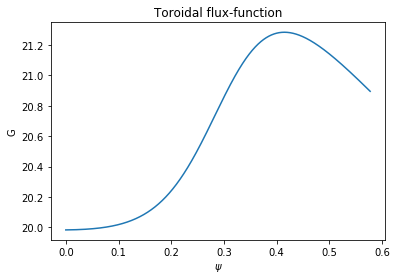

<Figure size 432x288 with 0 Axes>

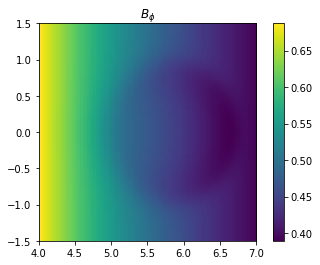

<Figure size 432x288 with 0 Axes>

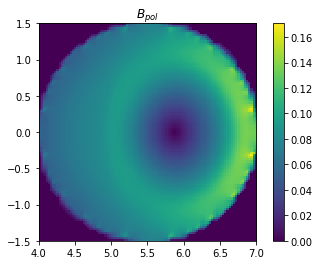

<Figure size 432x288 with 0 Axes>

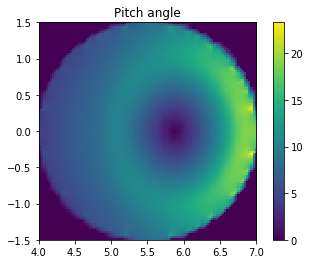

<Figure size 432x288 with 0 Axes>

In [350]:
tokamak(
    jprofile_width = 1.0,
    pprofile_width = 1.0,
    jprofile_loc   = 0.5,
    pprofile_loc   = 0.5,
    j0             = 1e6,
    p0             = 2e4,
    jbase = 5e4,
    b0 = 0.5,
    prefix = 'case2_'
)